<a href="https://www.kaggle.com/code/oscarm524/rob-sleep-prediction-eda-baseline?scriptVersionId=123187317" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Loading Libraries](#1)

[2. Reading Data Files](#2)

[3. Data Exploration](#3)

[4. Feature Engineering](#4)

[5. Baseline Modeling 1.0](#5)

[6. Baseline Modeling 2.0](#6)


<a id="1"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;"> Loading Libraries</h1>

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from datetime import datetime
from tqdm import tqdm

import holidays

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, GroupKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,SGDRegressor

<a id="2"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;"> Reading Data Files</h1>

In [2]:
train = pd.read_csv('/kaggle/input/kaggle-pog-series-s01e04/train.csv')
train['date'] = pd.to_datetime(train['date'])

train_detail = pd.read_csv('/kaggle/input/kaggle-pog-series-s01e04/train_detailed.csv')

test = pd.read_csv('/kaggle/input/kaggle-pog-series-s01e04/test.csv')
test['date'] = pd.to_datetime(test['date'])

submission = pd.read_csv('/kaggle/input/kaggle-pog-series-s01e04/sample_submission.csv')

<a id="2"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1>

In [3]:
print('The dimession of the train dataset is:', train.shape)
print('The dimession of the test dataset is:', test.shape)

The dimession of the train dataset is: (2354, 2)
The dimession of the test dataset is: (419, 2)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2354 non-null   datetime64[ns]
 1   sleep_hours  2354 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 36.9 KB


In [5]:
train.head()

,date,sleep_hours
0,2015-02-19,6.400000
1,2015-02-20,7.583333
2,2015-02-21,6.350000
3,2015-02-22,6.500000
4,2015-02-23,8.916667


In [6]:
train.describe()

,sleep_hours
count,2354.000000
mean,7.356560
std,2.213308
min,1.266667
25%,6.235417
50%,6.816667
75%,7.483333
max,17.433333


> <div class="alert alert-block alert-info">
<b>💡</b> Notice the outlier (17.43 hours) in the above table. We will further explore this in the next chart.
</div>

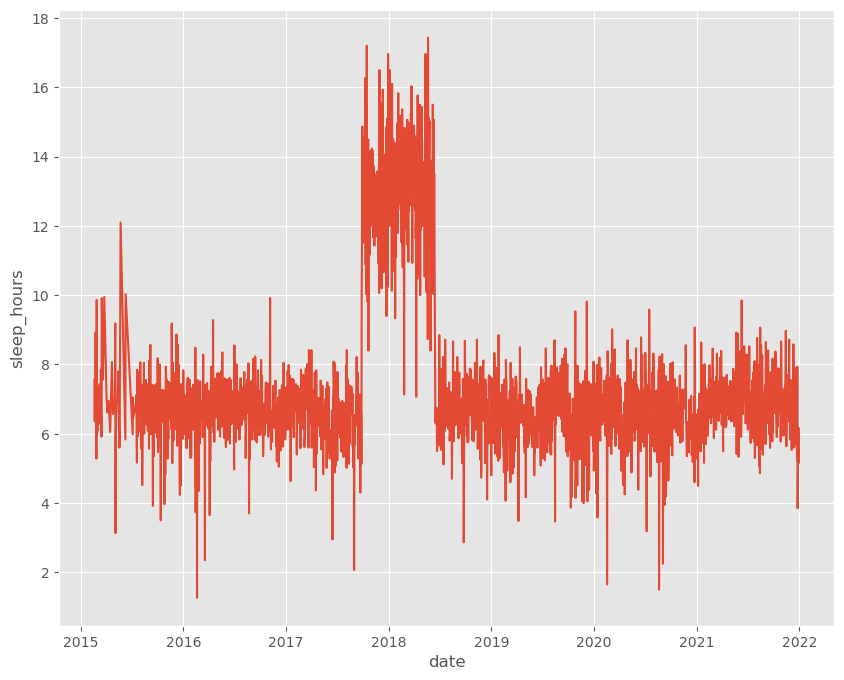

In [7]:
plt.figure(figsize = (10, 8))

sns.lineplot(data = train, x = 'date', y = 'sleep_hours');

> <div class="alert alert-block alert-info">
<b>💡</b> From the above chart, we see that there is a time window (09-2017 to 06-2018) in which the sleep hours look very different.   
</div>

Next, we proceed to build a baseline model to predict sleep hours.

<a id="4"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Feature Engineering</h1>

In this section, we engineer some basic features based on date.

In [8]:
def get_holidays(df):
    years_list = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

    holiday_US = holidays.CountryHoliday('US', years = years_list)
    holiday_dict = holiday_US.copy()

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
    return df.drop(columns = ['holiday_name'])


def feature_engineer(df):
    
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
#     new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    new_df["day"] = df["date"].dt.day
    new_df["day_sin"] = np.sin(new_df['day'] * (2 * np.pi / 12))
#     new_df["day_cos"] = np.cos(new_df['day'] * (2 * np.pi / 12))
    
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x <= 3 else(1 if x == 4 else (2 if x == 5 else (3))))
    
    new_df["day_of_year"] = df["date"].dt.dayofyear
    new_df["year"] = df["date"].dt.year
    
    return new_df

train = feature_engineer(train)
test = feature_engineer(test)

train = get_holidays(train)
test = get_holidays(test)

<a id="5"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1>

We first build a couple of linear models to predict sleep hours. Initially, we remove the observations which are different that the others. 

In [9]:
train_red = train[~((train['date'] >= '2017-09-27') & (train['date'] <= '2018-06-12'))].reset_index(drop = True)

X = train_red.drop(columns = ['date', 'sleep_hours', 'year'], axis = 1)
Y = train_red['sleep_hours']

test = test.drop(columns = ['date', 'sleep_hours', 'year'], axis = 1)

linear_preds = np.zeros(test.shape[0])
linear_rmse = 0

ridge_preds = np.zeros(test.shape[0])
ridge_rmse = 0

lasso_preds = np.zeros(test.shape[0])
lasso_rmse = 0

elastic_preds = np.zeros(test.shape[0])
elastic_rmse = 0

kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

for trn_idx, test_idx in kf.split(X, Y):
    
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = Y.iloc[trn_idx], Y.iloc[test_idx]
    
    ##################
    ## Linear model ##
    ##################
    
    linear_model = LinearRegression().fit(x_train, y_train)

    y_pred = linear_model.predict(x_valid)
    linear_rmse += mean_squared_error(y_pred, y_valid, squared = False) / kf.n_splits
    
    linear_pred = linear_model.predict(test)
    linear_pred = pd.Series(linear_pred) 
    linear_preds += linear_pred / kf.n_splits
    
    ###########
    ## Ridge ##
    ###########
    
    ridge_model = Ridge(alpha = 0.0999, tol = 1e-2, max_iter = 1000000, random_state = 0).fit(x_train, y_train)

    y_pred = ridge_model.predict(x_valid)
    ridge_rmse += mean_squared_error(y_pred, y_valid, squared = False) / kf.n_splits
    
    ridge_pred = ridge_model.predict(test)
    ridge_pred = pd.Series(ridge_pred) 
    ridge_preds += ridge_pred / kf.n_splits
    
    ###########
    ## Lasso ##
    ###########
    
    lasso_model = Lasso(alpha = 0.0999, tol = 1e-2, max_iter = 1000000, random_state = 0).fit(x_train, y_train)

    y_pred = lasso_model.predict(x_valid)
    lasso_rmse += mean_squared_error(y_pred, y_valid, squared = False) / kf.n_splits
    
    lasso_pred = lasso_model.predict(test)
    lasso_pred = pd.Series(lasso_pred) 
    lasso_preds += lasso_pred / kf.n_splits
    
    #############
    ## Elastic ##
    #############
    
    elastic_model = ElasticNet(alpha = 0.0002, l1_ratio = 0.001, random_state = 42).fit(x_train, y_train)

    y_pred = elastic_model.predict(x_valid)
    elastic_rmse += mean_squared_error(y_pred, y_valid, squared = False) / kf.n_splits
    
    elastic_pred = elastic_model.predict(test)
    elastic_pred = pd.Series(elastic_pred) 
    elastic_preds += elastic_pred / kf.n_splits 

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.994e+02, tolerance: 1.445e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.880e+02, tolerance: 1.413e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

We next proceed to compare model performance.

In [10]:
md_perf = pd.DataFrame({'Model': ['Linear', 'Ridge', 'Lasso', 'Elastic'], 
                        'CV-Score': [linear_rmse, ridge_rmse, lasso_rmse, elastic_rmse]})
md_perf

,Model,CV-Score
0,Linear,0.914466
1,Ridge,0.914436
2,Lasso,0.917553
3,Elastic,0.914738


> <div class="alert alert-block alert-info">
<b>💡</b> From the above table, we see that the ridge model has the smallest root mean square error. However, all the linear models more or less have the same cross-validation root mean square error.   
</div>

We next proceed to enseble the predictions using a simple weighted average (using the cross-validation rmse as weights).

In [11]:
w1 = 1/ linear_rmse  
w2 = 1/ ridge_rmse
w3 = 1/ lasso_rmse
w4 = 1/ elastic_rmse
wtot = w1 + w2 + w3 + w4

w1 = w1 / wtot
w2 = w2 / wtot
w3 = w3 / wtot
w4 = w4 / wtot

submission['sleep_hours'] = linear_preds * w1 + ridge_preds * w2 + lasso_preds * w3  + elastic_preds * w4
submission.head()

,date,sleep_hours
0,2022-01-01,6.901596
1,2022-01-02,6.939073
2,2022-01-03,6.587104
3,2022-01-04,6.589222
4,2022-01-05,6.593877


In [12]:
submission.to_csv('baseline_submission_1.csv', index = False)

In the 09-2017 to 06-2018 time window, it seems that `sleep_hours` have been double counted. Now, we divide `sleep_hours` by 2 in the 09-2017 to 06-2018 time window and re-train the models.

In [13]:
train.loc[((train['date'] >= '2017-09-27') & (train['date'] <= '2018-06-12')), 'sleep_hours'] = train.loc[((train['date'] >= '2017-09-27') & (train['date'] <= '2018-06-12')), 'sleep_hours'] / 2 

X = train.drop(columns = ['date', 'sleep_hours', 'year'], axis = 1)
Y = train['sleep_hours']

linear_preds = np.zeros(test.shape[0])
linear_rmse = 0

ridge_preds = np.zeros(test.shape[0])
ridge_rmse = 0

lasso_preds = np.zeros(test.shape[0])
lasso_rmse = 0

elastic_preds = np.zeros(test.shape[0])
elastic_rmse = 0

kf = KFold(n_splits = 30, shuffle = True, random_state = 42)

for trn_idx, test_idx in kf.split(X, Y):
    
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = Y.iloc[trn_idx], Y.iloc[test_idx]
    
    ##################
    ## Linear model ##
    ##################
    
    linear_model = LinearRegression().fit(x_train, y_train)

    y_pred = linear_model.predict(x_valid)
    linear_rmse += mean_squared_error(y_pred, y_valid, squared = False) / kf.n_splits
    
    linear_pred = linear_model.predict(test)
    linear_pred = pd.Series(linear_pred) 
    linear_preds += linear_pred / kf.n_splits
    
    ###########
    ## Ridge ##
    ###########
    
    ridge_model = Ridge(alpha = 0.0999, tol = 1e-2, max_iter = 1000000, random_state = 0).fit(x_train, y_train)

    y_pred = ridge_model.predict(x_valid)
    ridge_rmse += mean_squared_error(y_pred, y_valid, squared = False) / kf.n_splits
    
    ridge_pred = ridge_model.predict(test)
    ridge_pred = pd.Series(ridge_pred) 
    ridge_preds += ridge_pred / kf.n_splits
    
    ###########
    ## Lasso ##
    ###########
    
    lasso_model = Lasso(alpha = 0.0999, tol = 1e-2, max_iter = 1000000, random_state = 0).fit(x_train, y_train)

    y_pred = lasso_model.predict(x_valid)
    lasso_rmse += mean_squared_error(y_pred, y_valid, squared = False) / kf.n_splits
    
    lasso_pred = lasso_model.predict(test)
    lasso_pred = pd.Series(lasso_pred) 
    lasso_preds += lasso_pred / kf.n_splits
    
    #############
    ## Elastic ##
    #############
    
    elastic_model = ElasticNet(alpha = 0.0002, l1_ratio = 0.001, random_state = 42).fit(x_train, y_train)

    y_pred = elastic_model.predict(x_valid)
    elastic_rmse += mean_squared_error(y_pred, y_valid, squared = False) / kf.n_splits
    
    elastic_pred = elastic_model.predict(test)
    elastic_pred = pd.Series(elastic_pred) 
    elastic_preds += elastic_pred / kf.n_splits 

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.398e+02, tolerance: 1.927e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.448e+02, tolerance: 1.936e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

We next proceed to compare model performance.

In [14]:
md_perf = pd.DataFrame({'Model': ['Linear', 'Ridge', 'Lasso', 'Elastic'], 
                        'CV-Score': [linear_rmse, ridge_rmse, lasso_rmse, elastic_rmse]})
md_perf

,Model,CV-Score
0,Linear,0.902437
1,Ridge,0.902408
2,Lasso,0.905345
3,Elastic,0.902320


> <div class="alert alert-block alert-info">
<b>💡</b> From the above table, we see that the elastic model has the smallest root mean square error. Moreover, all the linear models have a better cross-validation root mean square error.
</div>

We next proceed to enseble the predictions using a simple weighted average (using the cross-validation rmse as weights).

In [15]:
w1 = 1/ linear_rmse  
w2 = 1/ ridge_rmse
w3 = 1/ lasso_rmse
w4 = 1/ elastic_rmse
wtot = w1 + w2 + w3 + w4

w1 = w1 / wtot
w2 = w2 / wtot
w3 = w3 / wtot
w4 = w4 / wtot

submission['sleep_hours'] = linear_preds * w1 + ridge_preds * w2 + lasso_preds * w3  + elastic_preds * w4
submission.head()

,date,sleep_hours
0,2022-01-01,6.896554
1,2022-01-02,6.905363
2,2022-01-03,6.603538
3,2022-01-04,6.604281
4,2022-01-05,6.606506


In [16]:
submission.to_csv('baseline_submission_2.csv', index = False)

In [17]:
submission['sleep_hours'] = elastic_preds 
submission.to_csv('baseline_submission_3.csv', index = False)

Finally, we re-train the models in the entire train dataset.

In [18]:
linear_model = LinearRegression().fit(X, Y)
linear_preds = linear_model.predict(test)

ridge_model = Ridge(alpha = 0.0999, tol = 1e-2, max_iter = 1000000, random_state = 0).fit(X, Y)
ridge_preds = ridge_model.predict(test)

lasso_model = Lasso(alpha = 0.0999, tol = 1e-2, max_iter = 1000000, random_state = 0).fit(X, Y)
lasso_preds = lasso_model.predict(test)

electic_model = ElasticNet(alpha = 0.0002, l1_ratio = 0.001, random_state = 42).fit(X, Y)
electic_preds = electic_model.predict(test)

submission['sleep_hours'] = 0.25*linear_preds + 0.25*ridge_preds + 0.25*lasso_preds  + 0.25*elastic_preds
submission.head()

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.711e+02, tolerance: 1.990e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


,date,sleep_hours
0,2022-01-01,6.896390
1,2022-01-02,6.905270
2,2022-01-03,6.603573
3,2022-01-04,6.604315
4,2022-01-05,6.606537


In [19]:
submission.to_csv('baseline_submission_4.csv', index = False)

<a id="5"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 2.0</h1>

In this section, we use the popular XGBoost model as baseline.

In [20]:
xgb_cv_scores, xgb_preds = list(), list()

for i in tqdm(range(1)):

    skf = KFold(n_splits = 30, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        #############
        ## XGBoost ##
        #############
        
        xgb_md = XGBRegressor(tree_method = 'hist',
                              colsample_bytree = 0.4, 
                              gamma = 1.25, 
                              learning_rate = 0.01, 
                              max_depth = 2, 
                              min_child_weight = 80, 
                              n_estimators = 2000, 
                              subsample = 1).fit(X_train, Y_train)
        
        ## Predicting on X_test and test        
        xgb_pred_1 = xgb_md.predict(X_test)
        xgb_pred_2 = xgb_md.predict(test)
        
        ## Computing rmse and storing test predictions
        xgb_cv_scores.append(mean_squared_error(Y_test, xgb_pred_1, squared = False))
        xgb_preds.append(xgb_pred_2)
        
xgb_cv_score = np.mean(xgb_cv_scores)
print('The oof root mean squared error of the XGBoost model is ', xgb_cv_score)

100%|██████████| 1/1 [01:17<00:00, 77.96s/it]

The oof root mean squared error of the XGBoost model is  0.8994518046200641


In [21]:
submission.to_csv('xgb_baseline_submission.csv', index = False)